# Using the Replica Trick to Compute Marginal Entropies

In [1]:
import sys
from pathlib import Path
sys.path = list(set(sys.path + ["../python"]))

In [2]:
import numpy
import pandas as pd
from gaussian_system import System, time_matrix, replica_estimate_sim, estimate_entropy_replica

In [3]:
path = Path.cwd().parent / "plots"
assert path.exists()
path

PosixPath('/Users/mr/Git/Gillespie/plots')

First define the system (i.e. the correlation functions)

In [4]:
system = System(lamda = 0.005, kappa = 0.25, rho = 0.01, mu = 0.01)

Set the trajectory length

In [5]:
traj_len = 500

In [6]:
def generate_replica_data():
    data = []
    for dim in [5, 50, 200]:
        data.append(replica_estimate_sim(system, dim, 64, 100, 100, 10))
        
    pd.concat(data, ignore_index=True).to_json(
        path / "replica" / "replica_data_1.json", orient="table"
    )

In [7]:
# generate_replica_data()

Run a linear model fit to find the slope of the replica lines

In [31]:
replica_data = pd.read_json(path / "replica" / "replica_data.json", orient="table")
replica_estimate, replica_points = estimate_entropy_replica(replica_data, allow_intercept=True)
replica_estimate.to_json(path / "replica" / "estimates.json", orient="table")
replica_estimate

,dim,delta_t,num_signals,num_responses,intercept,marginal_entropy,stderr
0,100,5.000000,550000,1000,-4.046866,206.792508,1.007777
1,160,3.125000,550000,1000,-9.089631,297.911051,1.972629
2,220,2.272727,550000,1000,-6.227229,377.445369,1.703905
3,280,1.785714,550000,1000,-8.293881,451.851880,2.553630
4,340,1.470588,550000,1000,15.073216,521.199430,2.946108
5,400,1.250000,550000,1000,15.020093,580.468989,3.360641


Now we plot the replica results

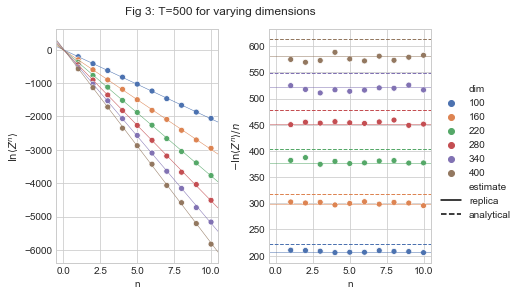

In [33]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, constrained_layout=True, subplot_kw={"xlim": (-0.5, 10.5)})

#palette = sns.dark_palette("green", replica_data.dim.unique().size)
palette = sns.color_palette("deep", replica_data.dim.unique().size)

sns.scatterplot(x="n", y="log_marginal_power", hue="dim", palette=palette, data=replica_points, ax=ax1, legend=None)
sns.scatterplot(x="n", y="-log_marginal_power/n", hue="dim", palette=palette, data=replica_points.assign(**{'-log_marginal_power/n': lambda x: -x['log_marginal_power']/x.n}), ax=ax2, legend=None)

replica_estimate["analytical"] = replica_estimate.astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")

for (i, est) in replica_estimate.iterrows():
    n = numpy.linspace(*ax1.get_xlim(), 10)
    ax1.plot(n, -est['marginal_entropy']*n + est['intercept'], color=palette[i], linewidth=0.5)
    ax2.plot(n, est['marginal_entropy'] * numpy.ones_like(n), color=palette[i], linewidth=0.5)
    ax2.plot(n, est['analytical']*numpy.ones_like(n), linestyle='--', color=palette[i], linewidth=1)

ax1.set(ylabel=r"$\ln \langle Z^n \rangle$")
ax2.set(ylabel=r"$-\ln \langle Z^n \rangle / n$")

patch = matplotlib.pyplot.scatter
legend_handles = [patch([], [], visible=False, label="dim")]
for (i, est) in replica_estimate.iterrows():
    legend_handles.append(patch([], [], color=palette[i], label=int(est.dim)))
patch = matplotlib.lines.Line2D
legend_handles.append(patch([], [], visible=False, label="estimate", color='black'))
legend_handles.append(patch([], [], label="replica", color='black'))
legend_handles.append(patch([], [], linestyle='--', label="analytical", color='black'))

from matplotlib.legend_handler import HandlerCircleCollection

legend = fig.legend(handles=legend_handles, bbox_to_anchor=(1, 0.5), loc='center left')
fig.suptitle("Fig 3: T=500 for varying dimensions")
fig.savefig(path / "replica" / "plot.pdf", bbox_inches='tight')

In [22]:
replica_estimate["analytical"] = replica_estimate.astype(object).apply(lambda s: system.marginal_entropy(time_matrix(s["dim"], s["delta_t"])), axis="columns")

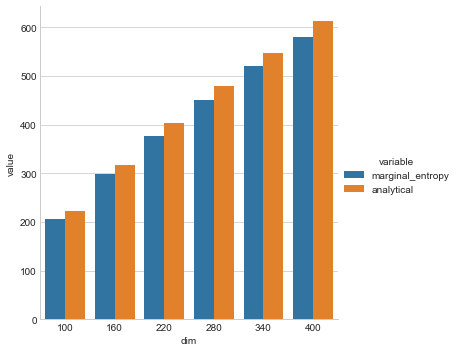

In [23]:
plot_data = replica_estimate.melt(["dim", "delta_t", "num_signals", "num_responses", "intercept"])
sns.catplot(x="dim", y="value", hue="variable", kind="bar", data=plot_data[plot_data.variable != "stderr"])